# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# import helper
# import fc_model

## Data

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Here we can see one of the images.

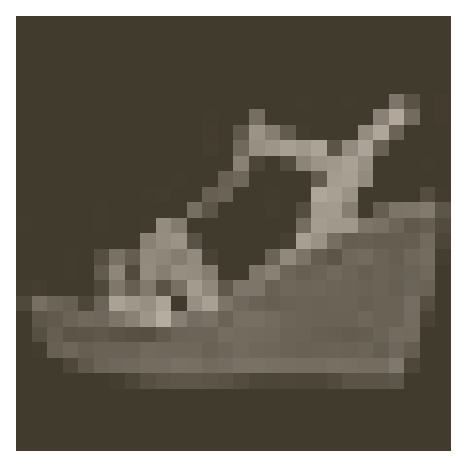

In [ ]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Define a Network

In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [6]:
# Create the network, define the criterion and optimizer

model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 0.561..  Test Loss: 0.507..  Test Accuracy: 0.816
Epoch: 1/2..  Training Loss: 0.596..  Test Loss: 0.490..  Test Accuracy: 0.813
Epoch: 1/2..  Training Loss: 0.543..  Test Loss: 0.486..  Test Accuracy: 0.823
Epoch: 1/2..  Training Loss: 0.549..  Test Loss: 0.478..  Test Accuracy: 0.825
Epoch: 1/2..  Training Loss: 0.541..  Test Loss: 0.493..  Test Accuracy: 0.820
Epoch: 1/2..  Training Loss: 0.558..  Test Loss: 0.484..  Test Accuracy: 0.824
Epoch: 1/2..  Training Loss: 0.561..  Test Loss: 0.477..  Test Accuracy: 0.827
Epoch: 1/2..  Training Loss: 0.551..  Test Loss: 0.491..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.523..  Test Loss: 0.481..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.548..  Test Loss: 0.461..  Test Accuracy: 0.829
Epoch: 1/2..  Training Loss: 0.552..  Test Loss: 0.460..  Test Accuracy: 0.826
Epoch: 1/2..  Training Loss: 0.528..  Test Loss: 0.468..  Test Accuracy: 0.829
Epoch: 1/2..  Training Loss: 0.534..  Test Loss: 0.4

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [9]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [13]:
model.state_dict()['hidden_layers.0.weight']

tensor([[ 0.0489,  0.0405,  0.0181,  ...,  0.0694,  0.0656,  0.0736],
        [ 0.0727,  0.0109,  0.0588,  ...,  0.0351,  0.0165,  0.0137],
        [ 0.0018,  0.0485, -0.0060,  ...,  0.0499,  0.0168,  0.0494],
        ...,
        [ 0.0068, -0.0170, -0.0070,  ..., -0.0170,  0.0168,  0.0249],
        [ 0.0314,  0.0550,  0.0011,  ...,  0.0243, -0.0025,  0.0049],
        [ 0.0678,  0.0624,  0.0192,  ...,  0.0332,  0.0503,  0.0250]])

The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [14]:
torch.save(model.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [16]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [20]:
# Try this
model = Network(784, 10, [512, 256, 128])
# This will throw an error because the tensor sizes are wrong!
print(f"Before loading:\n", model.state_dict()['hidden_layers.0.weight'])
model.load_state_dict(state_dict)
print(f"After loading:\n", model.state_dict()['hidden_layers.0.weight'])

Before loading:
 tensor([[ 0.0331, -0.0351,  0.0335,  ...,  0.0082, -0.0109, -0.0115],
        [ 0.0236, -0.0077, -0.0263,  ..., -0.0068,  0.0227,  0.0249],
        [ 0.0202,  0.0132, -0.0015,  ...,  0.0277, -0.0198, -0.0288],
        ...,
        [ 0.0146,  0.0148, -0.0102,  ...,  0.0301,  0.0340, -0.0160],
        [-0.0242, -0.0239, -0.0337,  ..., -0.0355,  0.0099, -0.0340],
        [ 0.0177,  0.0064, -0.0322,  ..., -0.0207,  0.0274,  0.0126]])
After loading:
 tensor([[ 0.0489,  0.0405,  0.0181,  ...,  0.0694,  0.0656,  0.0736],
        [ 0.0727,  0.0109,  0.0588,  ...,  0.0351,  0.0165,  0.0137],
        [ 0.0018,  0.0485, -0.0060,  ...,  0.0499,  0.0168,  0.0494],
        ...,
        [ 0.0068, -0.0170, -0.0070,  ..., -0.0170,  0.0168,  0.0249],
        [ 0.0314,  0.0550,  0.0011,  ...,  0.0243, -0.0025,  0.0049],
        [ 0.0678,  0.0624,  0.0192,  ...,  0.0332,  0.0503,  0.0250]])


This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [28]:
checkpoint = {'epoch:':3,
              'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

In [29]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    print(checkpoint)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [30]:
model = load_checkpoint('checkpoint.pth')
print(model)

{'epoch:': 3, 'input_size': 784, 'output_size': 10, 'hidden_layers': [512, 256, 128], 'state_dict': OrderedDict([('hidden_layers.0.weight', tensor([[ 0.0489,  0.0405,  0.0181,  ...,  0.0694,  0.0656,  0.0736],
        [ 0.0727,  0.0109,  0.0588,  ...,  0.0351,  0.0165,  0.0137],
        [ 0.0018,  0.0485, -0.0060,  ...,  0.0499,  0.0168,  0.0494],
        ...,
        [ 0.0068, -0.0170, -0.0070,  ..., -0.0170,  0.0168,  0.0249],
        [ 0.0314,  0.0550,  0.0011,  ...,  0.0243, -0.0025,  0.0049],
        [ 0.0678,  0.0624,  0.0192,  ...,  0.0332,  0.0503,  0.0250]])), ('hidden_layers.0.bias', tensor([-5.7604e-02, -7.5083e-02,  1.1817e-03, -2.8282e-02, -4.7104e-02,
        -3.2582e-02,  3.6512e-03, -1.4437e-02, -6.8242e-02, -2.1366e-02,
        -4.6246e-05, -2.5066e-02, -3.8371e-02, -2.6069e-02, -5.3620e-02,
         2.0232e-02, -7.3527e-03, -2.4176e-02, -6.4947e-02, -6.9247e-02,
         4.1745e-02, -5.6457e-02,  6.2275e-03, -4.6607e-02, -2.8482e-02,
         4.8369e-03, -2.2274e-02, 